<a href="https://colab.research.google.com/github/bloppaa/ED22-01-Cortes-Vega/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Código morse

El [**código morse**](https://es.wikipedia.org/wiki/C%C3%B3digo_morse), también conocido como **alfabeto morse** o **clave morse** es un sistema de representación de letras y números mediante señales emitidas de forma intermitente.

<img
  src='https://ea7fmt.wordpress.com/wp-content/uploads/2012/10/morse11.jpg'
  width=600>

A continuación se describe el procedimiento para convertir un texto dado a código morse.

Se inicializa un diccionario, el cual tiene el código en morse para cada letra y dígito del abecedario, además de algunos símbolos.

In [1]:
morse_dict: dict[str,str] = {
    'A': '.-',     'B': '-...',   'C': '-.-.',  'D': '-..',    'E': '.',
    'F': '..-.',   'G': '--.',    'H': '....',  'I': '..',     'J': '.---',
    'K': '-.-',    'L': '.-..',   'M': '--',    'N': '-.',     'Ñ': '--.--',
    'O': '---',    'P': '.--.',  'Q': '--.-',   'R': '.-.',    'S': '...',
    'T': '-',      'U': '..-',   'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..',  '0': '-----',  '1': '.----',  '2': '..---',
    '3': '...--',  '4': '....-', '5': '.....',  '6': '-....',  '7': '--...',
    '8': '---..',  '9': '----.', '.': '.-.-.-', ',': '--..--', '?': '..--..',
    '"': '.-..-.', '/': '-..-.',
}

Se separa cada palabra del texto con un slash `/`, y luego se itera por cada caracter de las palabras, asociando el caracter con su código.

In [2]:
def text_to_morse(text: str) -> str:
    '''
    Convert a text to morse code

    :param text: The text to convert
    :type text: str
    :return: The morse code
    :rtype: str
    '''
    return ' / '.join(' '.join(morse_dict[c.upper()] for c in word)
                      for word in text.split())

A continuación se realizan pruebas para verificar la correcta implementación de la función anterior.

In [5]:
tests = [
    ('sos', '... --- ...'),
    ('python', '.--. -.-- - .... --- -.'),
    ('123', '.---- ..--- ...--'),
    ('hello world', '.... . .-.. .-.. --- / .-- --- .-. .-.. -..'),
    ('', ''),
    ('a', '.-'),
    ('A', '.-'),
    ('HELLO', '.... . .-.. .-.. ---'),
    ('Hello World', '.... . .-.. .-.. --- / .-- --- .-. .-.. -..'),
]

for text, expected in tests:
    assert text_to_morse(text) == expected

## Onda sonora

El sonido es un tipo de onda mecánica. Se puede representar en función del tiempo:

$$y(t)=A\space\text{sin}(2\pi ft)$$

A continuación se describe el procedimiento para representar una onda senoidal en un arreglo. Se definen constantes globales para evitar inconsistencias en los cálculos.

In [6]:
# Frecuencia de muestreo
SAMPLE_RATE: int = 44100
# Frecuencia
FREQUENCY: int = 500

In [21]:
import numpy as np

def generate_wave(duration: float, frequency: int=FREQUENCY,
                  sample_rate: int=SAMPLE_RATE, A: float = 0.5) -> np.ndarray:
    '''
    Generate a wave based on the equation `Asin(2πft)`

    :param duration: The duration of the wave in seconds
    :type duration: float
    :param frequency: The frequency of the wave in Hz
    :type frequency: int, optional
    :param sample_rate: The sample rate of the wave in Hz
    :type sample_rate: int, optional
    :param A: The amplitude of the wave
    :type A: float, optional
    :return: The wave
    :rtype: np.ndarray
    '''
    t = np.linspace(0, duration, int(sample_rate * duration), False)
    return A * np.sin(2 * np.pi * frequency * t)


Se muestra una onda usando la librería `matplotlib` para verificar el correcto funcionamiento de la función.

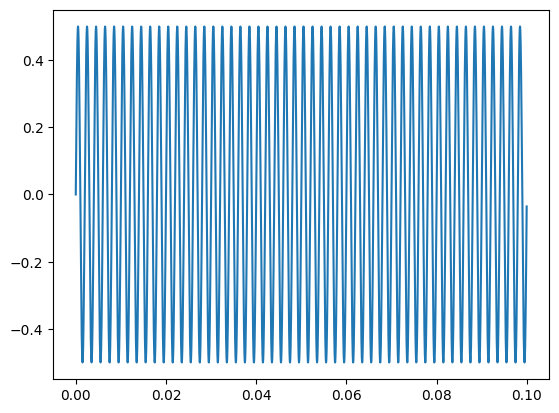

In [12]:
import matplotlib.pyplot as plt

# Sonido de 0.1 segundos de duración
t, y = generate_wave(0.1)
plt.plot(t, y)
plt.show()

También es necesario una función para generar silencio, la cual simplemente crea un array con ceros.

In [13]:
def generate_silence(duration: float, sample_rate: int=SAMPLE_RATE
                     ) -> np.ndarray:
    '''
    Generate a silence wave of a given duration

    :param duration: The duration of the silence in seconds
    :type duration: float
    :param sample_rate: The sample rate of the wave in Hz
    :type sample_rate: int, optional
    :return: The silence wave
    :rtype: np.ndarray
    '''
    return np.zeros(int(sample_rate * duration))


Se muestra la onda usando la librería `matplotlib` (debería ser una línea recta).

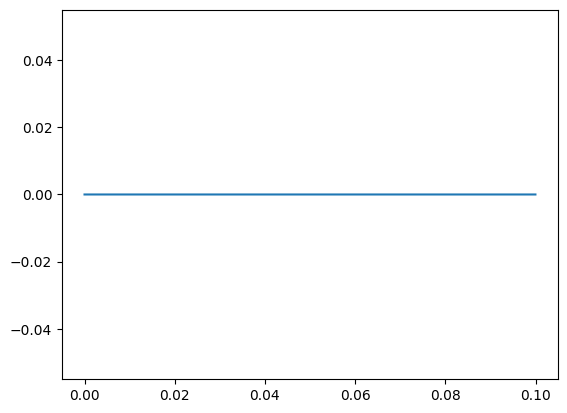

In [16]:
t = generate_wave(0.1)[0]
y = generate_silence(0.1)
plt.plot(t, y)
plt.show()

## Timing

Por último, es necesario entender cómo funciona el timing del código morse. El [**timing**](https://morsecode.world/international/timing.html) en código morse está basado en relación a la duración de un *dit*. A partir de esta duración se puede derivar la duración de un *dah* y las distintas pausas:

* Dit: 1 unidad
* Dah: 3 unidades
* Espacio intra-caracter (espacio entre dits y dahs dentro de un caracter): 1 unidad
* Espacio inter-caracter (espacio entre caracteres de una palabra): 3 unidades
* Espacio de palabra: 7 unidades

Dada esta definición, se definen nuevas variables para trabajar con estos valores.

In [47]:
# 0.1 segundos
dit = 0.1
DAH = 3 * dit
SPACE_INTRA = dit
SPACE_INTER = 3 * dit
SPACE_WORD = 7 * dit

timing: dict = {
    '.': dit,
    '-': DAH,
    '|': SPACE_INTRA,
    ' ': SPACE_INTER,
    '/': SPACE_WORD,
}

Se define una función para convertir un texto a una onda senoidal.

In [28]:
def text_to_wave(text: str) -> np.ndarray:
    '''
    Convert a text to a sound wave

    :param text: The text to convert
    :type text: str
    :return: The sound wave
    :rtype: np.ndarray
    '''
    wave = np.array([])
    morse = text_to_morse(text)

    # Reformat morse code to easier parse durations
    fmorse = ''
    for word in morse.split(' / '):
        letters = []
        for letter in word.split():
            letters.append('|'.join(letter))
        fmorse += ' '.join(letters) + '/'
    fmorse = fmorse[:-1]

    for char in fmorse:
        duration = timing[char]
        if char in ' |/':
            wave = np.concatenate((wave, generate_silence(duration)))
        elif char in '.-':
            wave = np.concatenate((wave, generate_wave(duration)))

    return wave

Representación gráfica de una señal SOS

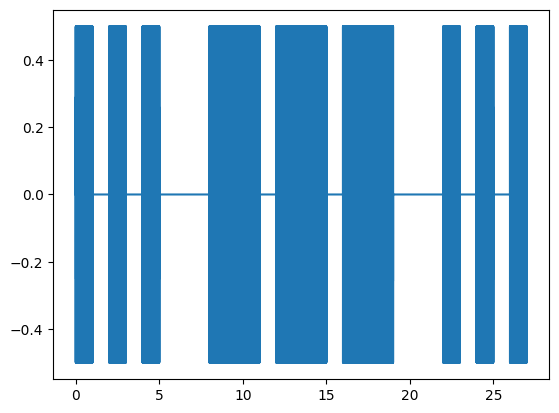

In [43]:
wave = text_to_wave('sos')
time = np.linspace(0, len(wave) / SAMPLE_RATE, len(wave))
plt.plot(time, wave)
plt.show()

Con todas las funciones definidas, es momento de transformar un texto a un archivo mp3 con el código morse. Es necesario instalar dependencias adicionales que no vienen instaladas por defecto en Colab.

In [30]:
!pip install pydub

In [31]:
import pydub

def text_to_audio(text: str) -> pydub.AudioSegment:
    '''
    Convert a text to an audio file with the morse code

    :param text: The text to convert
    :type text: str
    :return: The audio file with the morse code
    :rtype: pydub.AudioSegment
    '''
    # Boilerplate code
    # Just transforms a sound wave to an AudioSegment
    wave_integers = np.int16(text_to_wave(text) * 32767)
    return pydub.AudioSegment(
        wave_integers.tobytes(),
        frame_rate=SAMPLE_RATE,
        sample_width=wave_integers.dtype.itemsize,
        channels=1
    )

Finalmente exportamos un texto como un archivo mp3 para comprobar los resultados.

In [50]:
text = 'SOS'
audio = text_to_audio(text)
audio.export('sos.mp3', format='mp3')

<_io.BufferedRandom name='sos.mp3'>